# MNIST VAE with enumeration of discrete latent variable

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints

### Helper function

In [3]:
def show_batch(images,nrow=4,npadding=10):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    batch, ch, width, height = images.shape
    if(images.device != "cpu"):
        images=images.cpu()
    grid = utils.make_grid(images,nrow, npadding, normalize=True, range=None, scale_each=True, pad_value=1)       
    imshow(grid.detach().numpy().transpose((1, 2, 0))) 
    
def train_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
            
        loss = svi.step(imgs)
        
        if(verbose):
            print("i= %3d train_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def evaluate_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        if torch.cuda.is_available():
            imgs=imgs.cuda()
        
        loss = svi.evaluate_loss(imgs)
        
        if(verbose):
            print("i= %3d  test_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def save_obj(obj,root_dir,name):
    with open(root_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(root_dir,name):
    with open(root_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    torch.save(model.state_dict(),full_file_path)
    
def load_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    model.load_state_dict(torch.load(full_file_path))

### Define the simulation parameters

In [4]:
params = { 
    'K' : 10, #number of clusters
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'K': 10, 'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'Z_DIM': 2, 'use_cuda': True}


### Get the data

torch.Size([16, 1, 28, 28])


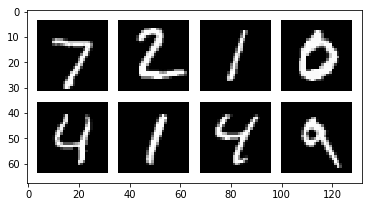

In [5]:
BATCH_SIZE = 16
kwargs = {'num_workers': 1, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class

In [6]:
class ENCODER(torch.nn.Module):
    """ x -> p """
    
    def __init__(self, params):
        super().__init__()
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        self.comp_p  = torch.nn.Linear(self.x_dim,self.K, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self,x):
        batch_size = x.shape[0]
        x1 = x.view(batch_size,-1)
        p = self.softmax(self.comp_p(x1))
        return p
    
class DECODER(torch.nn.Module):
    """ z -> x """
    
    def __init__(self, params):
        super().__init__()
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        self.comp_x_mu  = torch.nn.Linear(self.z_dim,self.x_dim, bias=True)
         
    def forward(self,z):
        batch_size = z.shape[0]
        x_mu = torch.sigmoid(self.comp_x_mu(z)).view(batch_size,self.ch,self.height,self.width)
        return x_mu
        


class VAE(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference to get: zwhere,zwhat
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)

        # Global variables
        locs_mu = pyro.param("locs_mu",imgs.new_zeros(self.K,self.z_dim))
        locs_q = pyro.sample('locs', dist.Delta(locs_mu).to_event(1))
        
        scales_mu = pyro.param("scales_mu",imgs.new_ones(self.K,self.z_dim),constraint=constraints.positive)
        scales_q = pyro.sample('scales', dist.Delta(scales_mu).to_event(1))
        
        concentrations = pyro.param("concentrations",imgs.new_ones(self.K),constraint=constraints.positive)
        weights_q = pyro.sample('weights', dist.Dirichlet(concentrations))
        
        with pyro.plate('batch_size', batch_size, dim=-1):
            p = self.encoder(imgs)
            assignment = pyro.sample('assignment',dist.Categorical(p))
            z = pyro.sample('z_style', dist.Normal(locs_q[assignment], scales_q[assignment]).to_event(1))
        return p,z
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
                - z_type ~ Categorical(weights) 
                - z_style ~ N(loc,scale) 
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        
        # Global variable
        weights = pyro.sample('weights', dist.Dirichlet(0.5 * imgs.new_ones(self.K)))

        # Variable for each components
        with pyro.plate('components', self.K, dim=-1):
            locs = pyro.sample('locs', dist.Normal(0., 10.*imgs.new_ones(self.K,self.z_dim)).to_event(1))
            scales = pyro.sample('scales', dist.LogNormal(0., 2.*imgs.new_ones(self.K,self.z_dim)).to_event(1))


        # Variable for each image
        with pyro.plate('batch_size', batch_size, dim=-1):
            assignment = pyro.sample('assignment', dist.Categorical(weights))
            z = pyro.sample('z_style', dist.Normal(locs[assignment], scales[assignment]).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Bernoulli(x_mu.view(-1,self.x_dim)).to_event(1), obs=imgs.view(-1,self.x_dim))
    


In [24]:
encoder = ENCODER(params)
decoder = DECODER(params)
vae = VAE(params,encoder,decoder)
vae.guide()
vae.model()

load_model(vae,"/home/ldalessi/VAE_MINST/ARCHIVE/","vae_v5_200")

In [25]:
imgs,labels = next(iter(testloader))

p,z = vae.guide(imgs.cuda())
z = z.detach().cpu()
print(p[:2,:])

tensor([[0.1191, 0.0750, 0.1199, 0.1065, 0.1153, 0.0858, 0.0835, 0.0899, 0.0916,
         0.1134],
        [0.1305, 0.0950, 0.0909, 0.0807, 0.0834, 0.0954, 0.1157, 0.1283, 0.1147,
         0.0654]], device='cuda:0', grad_fn=<SliceBackward>)


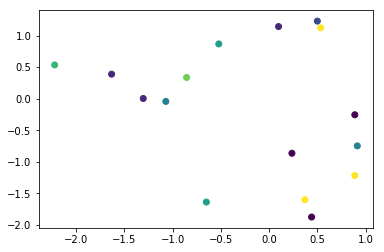

In [26]:
#print(p)
#print(labels)
plt.scatter(z[:,0].numpy(),z[:,1].numpy(), c=labels)